In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots
from fibonacci import generate_vertices
from linear_discetisation import Linear_disc_points
from commutators import test_angular_momentum_comutator, fourier_vector, calc_r
from lattice_actions import calc_mean_distance

LinAlgError: Singular matrix

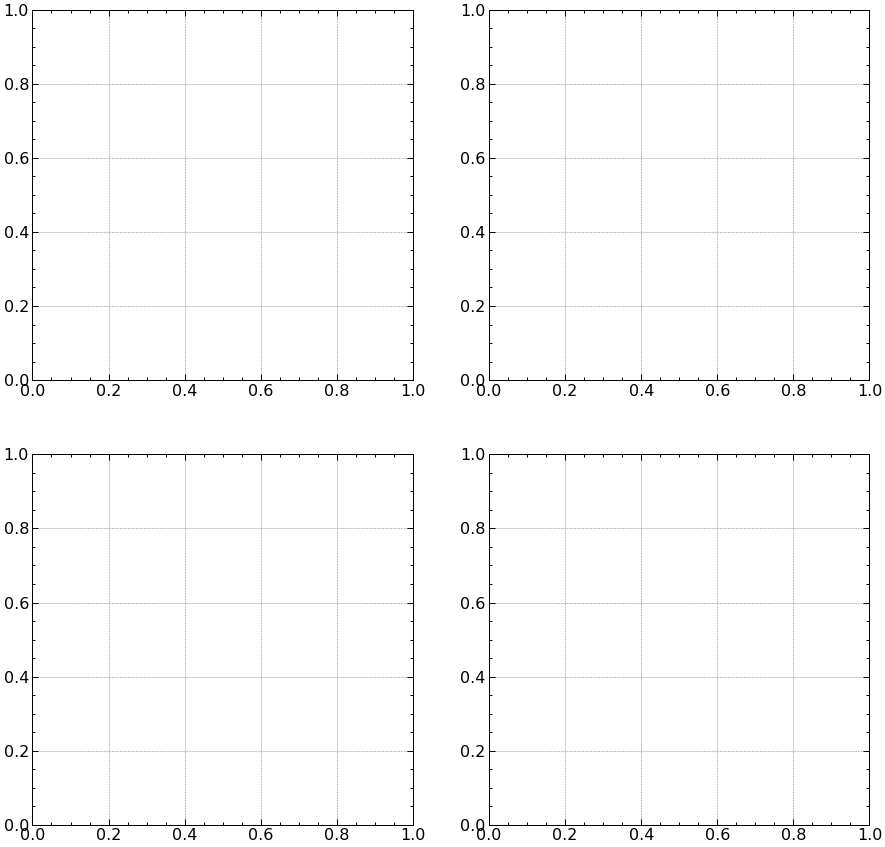

In [2]:
fig, axes = plt.subplots(2,2,figsize=(15,15))
N = np.array([2**i for i in range(4,10)])
Lattices = [generate_vertices(i) for i in N]
Lattices = [Linear_disc_points(i) for i in range(4,10)]
mean_distances= []
rs = []
k = np.array([0,0,0])

for n in [1,2]:
    for a in [1,2,3]:
        for i in [0,1]:
            for j in [0,1]:
                for vertex in Lattices:
                    comm = test_angular_momentum_comutator(vertex, a, n=n, i=i,j=j)
                    vec = fourier_vector(vertex, a, k)
                    rs.append(calc_r(comm, vec=vec))
                    mean_distances.append(calc_mean_distance(vertex))
                #plot here
                ax = axes[i][j]
                ax.set_title(f"i={i}, j={j}")
                ax.plot(mean_distances, rs, "o--", label=f"n={n},a={a}")
                ax.set_ylabel("r")
                ax.set_xlabel("mean_distances")
                ax.legend(loc="best")
                ax.set_yscale("log")
                #end
                mean_distances = []
                rs = []


\begin{equation*}
    z = \big([L_a,U_{il}] - (t_a)_{ji} U_{il})\cdot v(k)
\end{equation*}

\begin{equation*}
    r = \frac{1}{N}\sum_i |z_i|
\end{equation*}

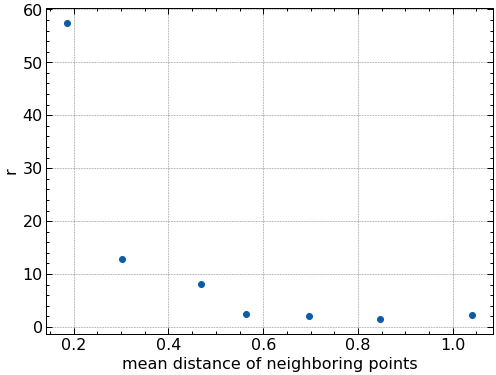

In [ ]:
plt.plot(mean_distances, rs, "o")
plt.xlabel("mean distance of neighboring points")
plt.ylabel("r")
#plt.yscale("log")
plt.show()

In [ ]:
figsize = (8,6)

### Eigenvalues

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots
from fibonacci import generate_vertices, generate_vertices_angles
from lattice_optimisation import lattice_optimizer, angles_to_cartesian
from hamiltonian import calc_eigenvals, continuum_spectrum

num_eigenvals = 50
id_s = list(range(num_eigenvals))
eigenvals = continuum_spectrum(num_eigenvals)


neighbors = [1,2,3]
exponents = [6,8,10, 11]
fib_Lattices = [generate_vertices(2**i) for i in exponents]
optim_Lattices = [angles_to_cartesian(lattice_optimizer(generate_vertices_angles(2**i))[0]) for i in exponents]

fib_eigenvals = np.zeros((len(neighbors),len(exponents), num_eigenvals))
optim_eigenvals = np.zeros((len(neighbors),len(exponents), num_eigenvals))
print(fib_eigenvals.shape)

for index, (exponent, fib, optim) in enumerate(zip(exponents,fib_Lattices, optim_Lattices)):
    for i,n in enumerate(neighbors):
        fib_eigenvals[i,index,:] = calc_eigenvals(fib, k=num_eigenvals, n=n)
        optim_eigenvals[i,index,:] = calc_eigenvals(optim, k=num_eigenvals, n=n)

(3, 4, 50)


<ipython-input-20-b8bea24411e5>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  fib_eigenvals[i,index,:] = calc_eigenvals(fib, k=num_eigenvals, n=n)
<ipython-input-20-b8bea24411e5>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  optim_eigenvals[i,index,:] = calc_eigenvals(optim, k=num_eigenvals, n=n)


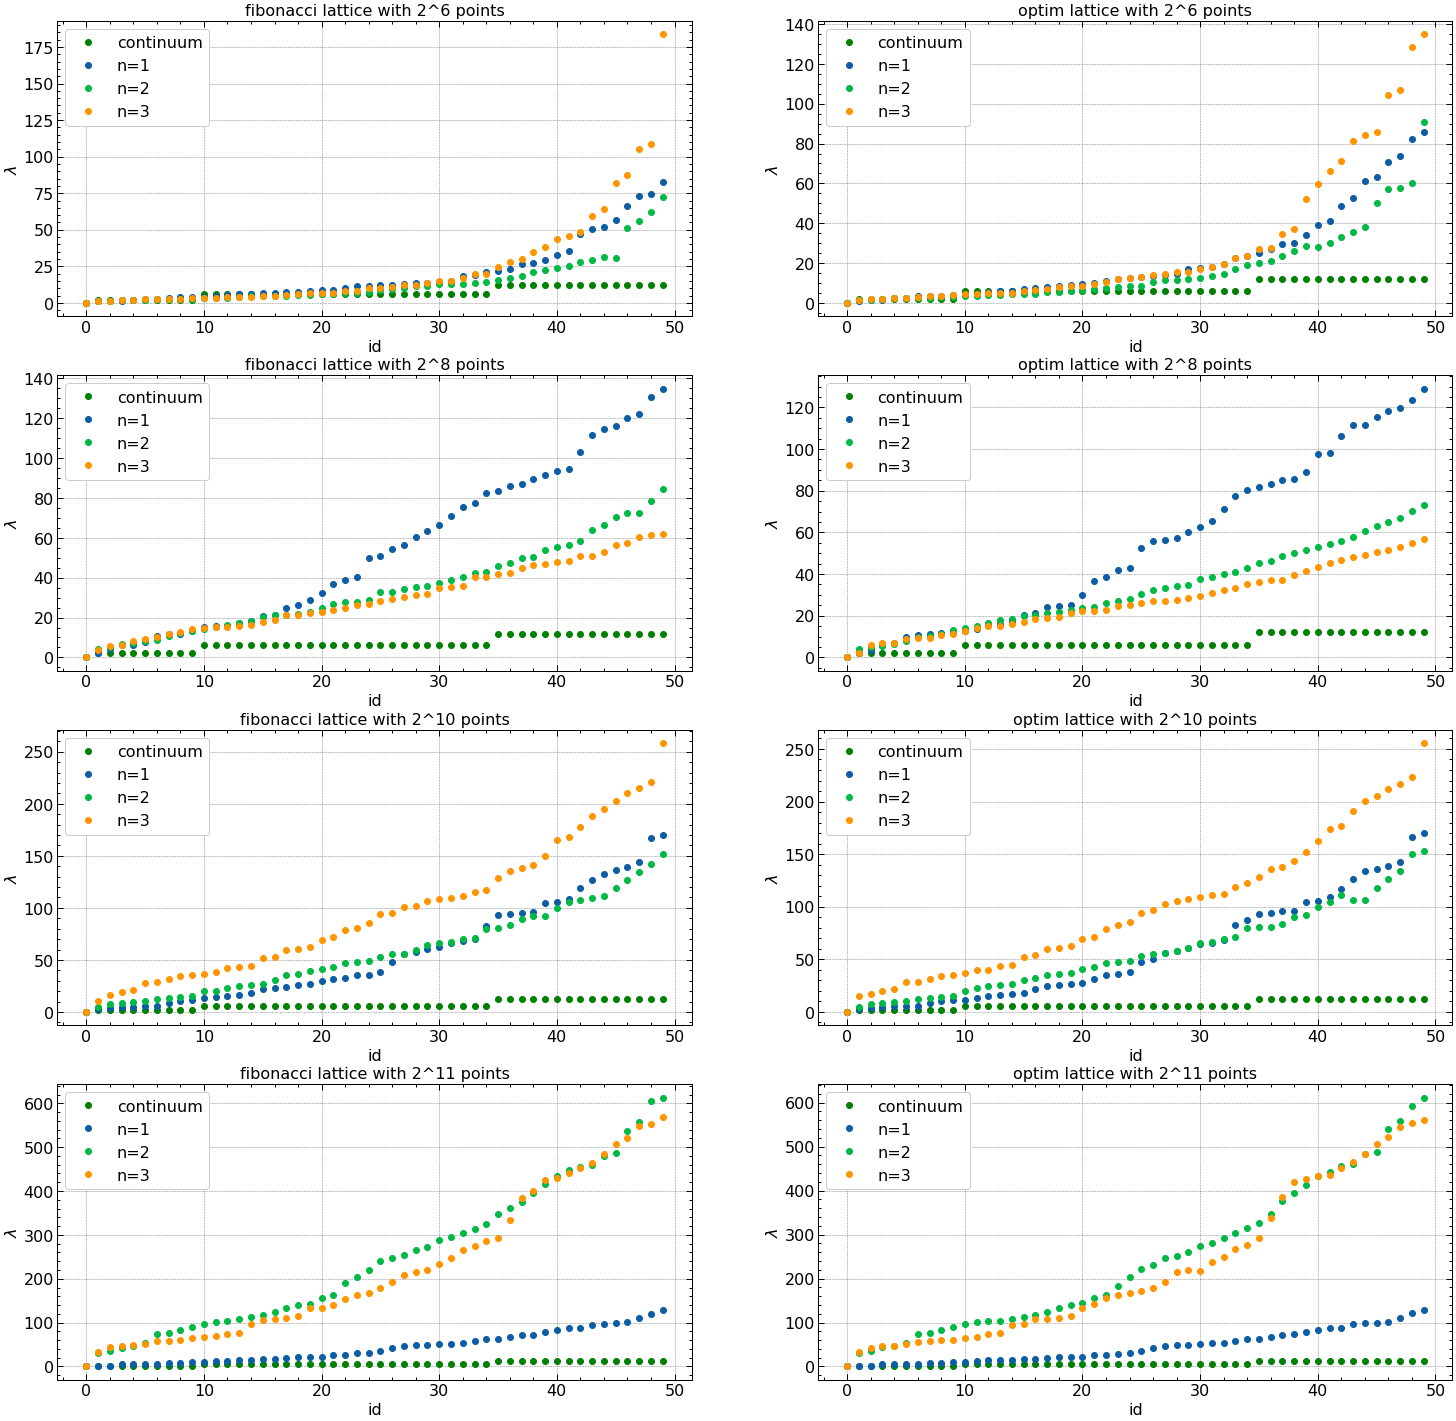

In [22]:
fig, axes = plt.subplots(len(exponents),2,figsize=(25,25))

for index, exponent in enumerate(exponents):
    ax = axes[index,:]
    ax[0].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    ax[1].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    for i,n in enumerate(neighbors):
        ax[0].plot(id_s, fib_eigenvals[i,index,:], "o", label=rf"n={n}")
        ax[1].plot(id_s, optim_eigenvals[i,index,:], "o", label=rf"n={n}")
    ax[0].set_title(rf"fibonacci lattice with 2^{exponent} points")
    ax[1].set_title(rf"optim lattice with 2^{exponent} points")
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")
    ax[0].set_xlabel("id")
    ax[1].set_xlabel("id")
    ax[0].set_ylabel(r"$\lambda$")
    ax[1].set_ylabel(r"$\lambda$")




##### Idea:
use and maximise
\begin{equation*}
    y = \frac{1}{N}\sum_{i \ne j} d(X_i, X_j) + \lambda(R-1)
\end{equation*}
by using spherical coordinates and restricting the sum to the nearest n neighbors of each Lattice point $X_i$ now consisting of the three angles $X_i = (\psi_i, \theta_i, \Phi_i)$
\begin{equation*}
    y = \frac{1}{N}\sum_{i \ne j} NO
\end{equation*}
(this is the mean distance of the nearest n neighbors of each Lattice point; $N = n\cdot dim(X_i)$)

##### Implementation:
then calculating the gradient $\nabla y$ and iteratively adding it to the current Lattice coordinates as
\begin{equation*}
    X_{new} = X_{old} + d\nabla y
\end{equation*}

using the difference $|y_{new} - y_{old}| < \epsilon$ as a cutoff as well as the factor $d$ (I don't know why using this as $d$ works as well as it does)

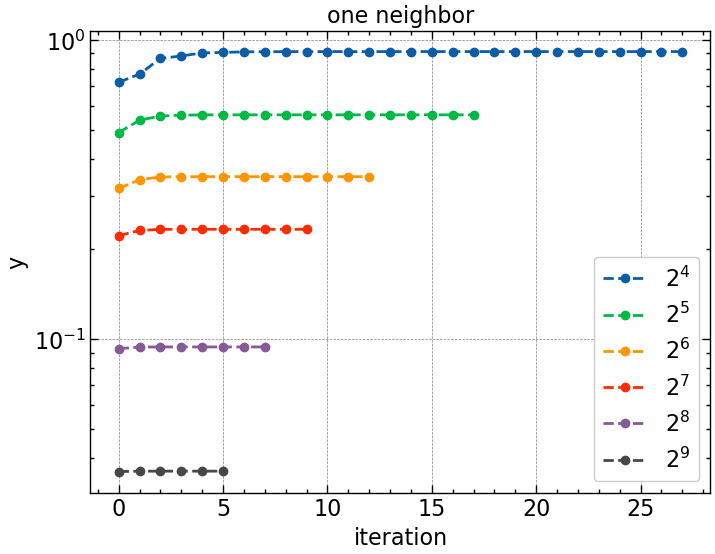

In [ ]:
from lattice_optimisation import lattice_optimizer
from fibonacci import generate_vertices_angles

N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=1)

    plt.plot(arr,"o--", label=rf"$2^{exp}$")


plt.xlabel("iteration")
plt.ylabel("y")
plt.legend(loc="best")
plt.title("one neighbor")
plt.yscale("log")
plt.show()

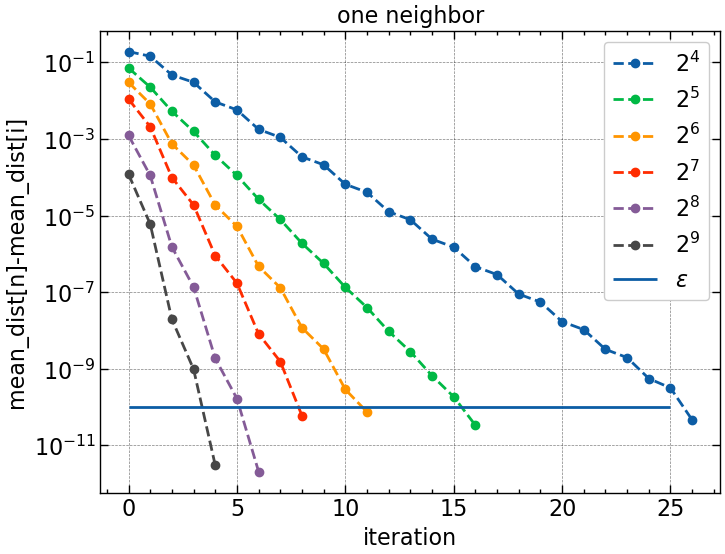

In [ ]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=1)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("one neighbor")
plt.yscale("log")
plt.show()

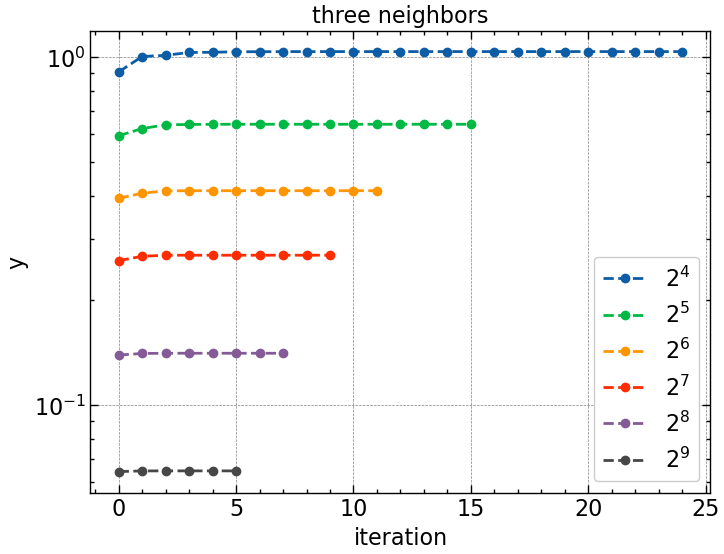

In [ ]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=3)
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.xlabel("iteration")
plt.ylabel("y")
plt.legend(loc="best")
plt.title("three neighbors")
plt.yscale("log")
plt.show()

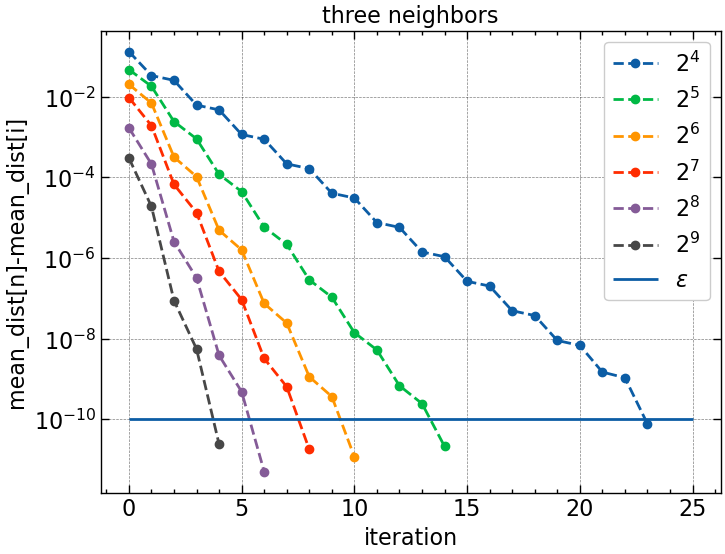

In [ ]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=3)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("three neighbors")
plt.yscale("log")
plt.show()

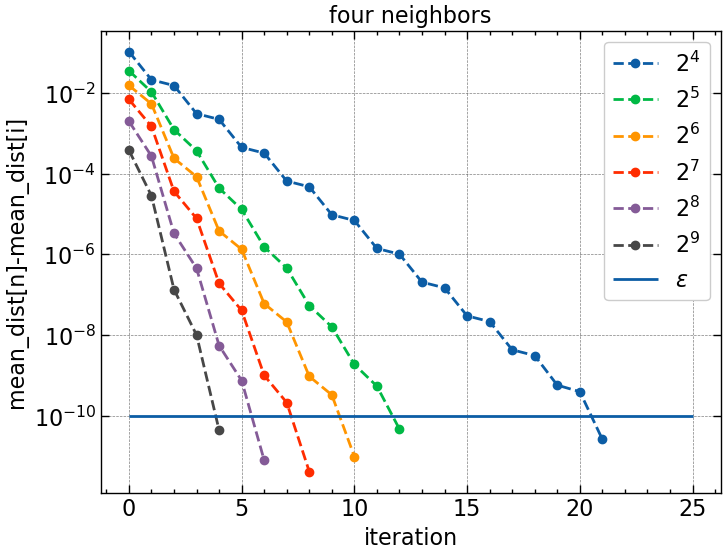

In [ ]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=4)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("four neighbors")
plt.yscale("log")
plt.show()

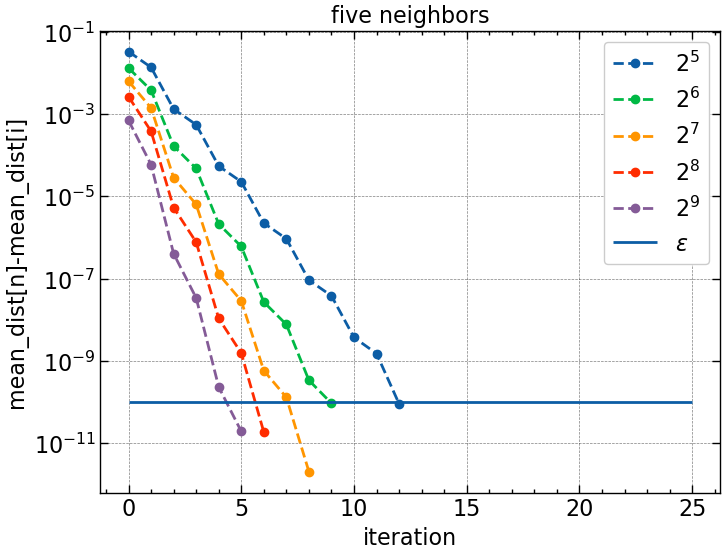

In [ ]:
N = np.array([i for i in range(5,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=5)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("five neighbors")
plt.yscale("log")
plt.show()